In [1]:
from google.colab import drive
drive.mount('/content.drive/')


Mounted at /content.drive/


<img src= "https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px">
<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center" > Scipy pour le traitement d'images </h1>
<hr style="border-width:2px;border-color:#75DFC1">

> Dans ce notebook nous allons plonger dans le monde du traitement d'image 3D en utilisant `Scipy`. Nous allons travailler sur des radiographies produites par un Scan 3D. La radiographie est faite sur l'intégralité du corps d'un patient. Notre objectif consiste à créer des masques 3D permettant d'isoler les poumons.   
>
> Nous allons importer les librairies nécessaires ainsi qu'une image 3D sous la forme d'un tableau `Numpy`
>
> Références :
>
> 1) le Github de Sergey Primakov https://github.com/primakov
>
> 2) le Github de Luke Polson https://github.com/lukepolson (youtube channel [Mr P. Solver](https://www.youtube.com/@MrPSolver))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

In [5]:
filepath = '/content.drive/MyDrive/Datatelier_Scipy/ct_pm_scan.npy'
img = np.load(filepath)
print(img.shape)
print(list(img[0, 100, :]))

(263, 512, 512)
[-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -986, -988, -987, -1000, -991, -989, -998, -1000, -993, -984, -993, -987, -989, -998, -997, -992, -1000, -985, -976, -984, -991, -977, -1000, -995, -983, -981, -992, -990, -987, -994, -981, -990, -974, -974, -991, -972, -981, -988, -993, -982, -965, -978, -962, -962, -959, -963, -977, -958, -939, -937, -939, -894, -889, -799, -540, -190, 63, 110, 87, 64, 86, 49, -173, -473, -716, -819, -864, -863, -866, -869, -880, -886, -888, -892, -895, -894, -891, -888, -894, -895, -894, -903, -895, -889, -898, -888, -907, -909, -906, -887, -895, -896, -901, -888, -879, -901, -892, -897, -886, -878, -880, -903, -890, -

> Nous allons afficher 6 images correspondantes à trois régions différentes du corps du patient.

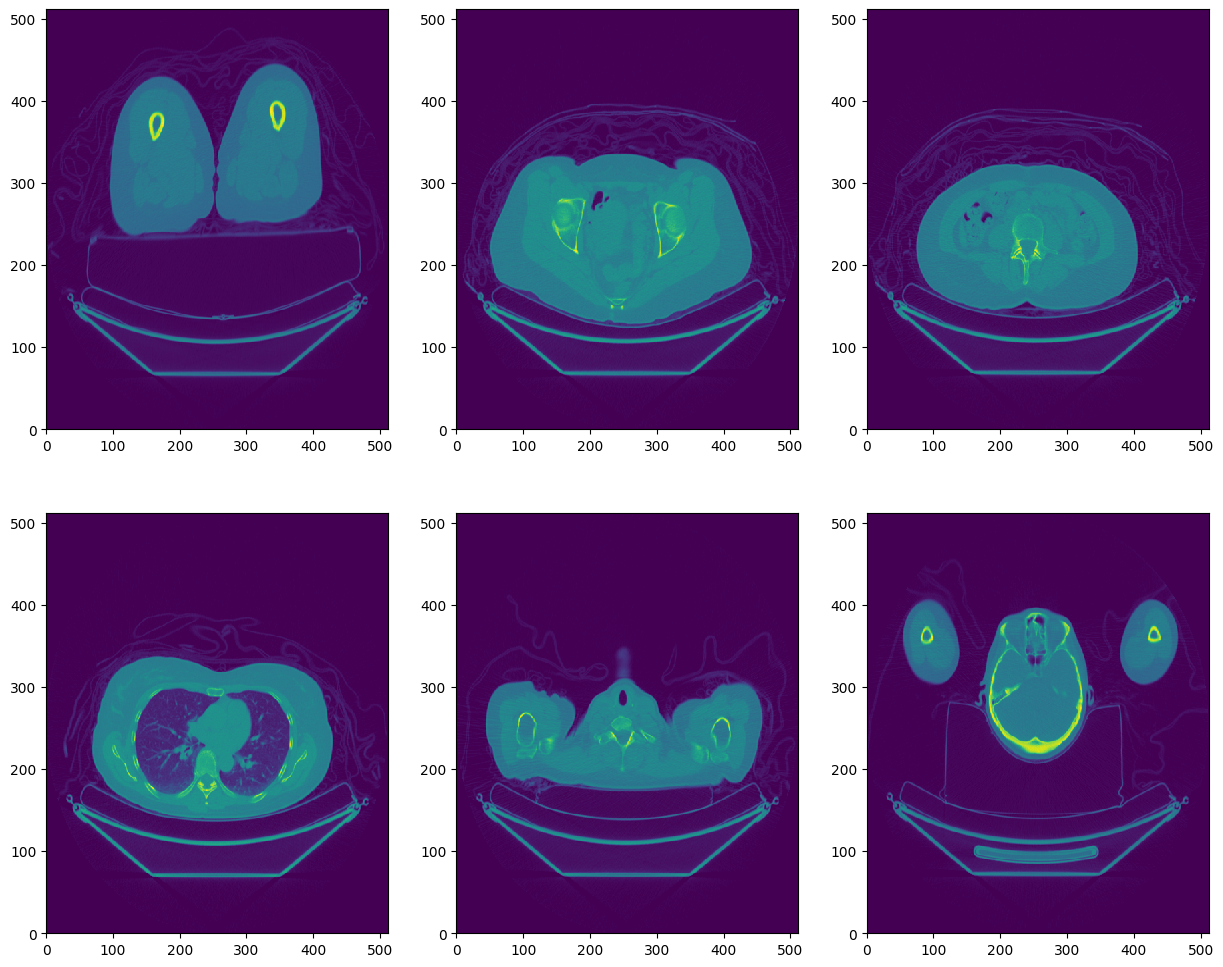

In [6]:
index = np.array([0, 55, 100, 170, 210, 250])

plt.figure(figsize = (15, 12))

for i, index in enumerate(index, start = 1) :
  plt.subplot(2,3, i)
  plt.pcolormesh(img[index])




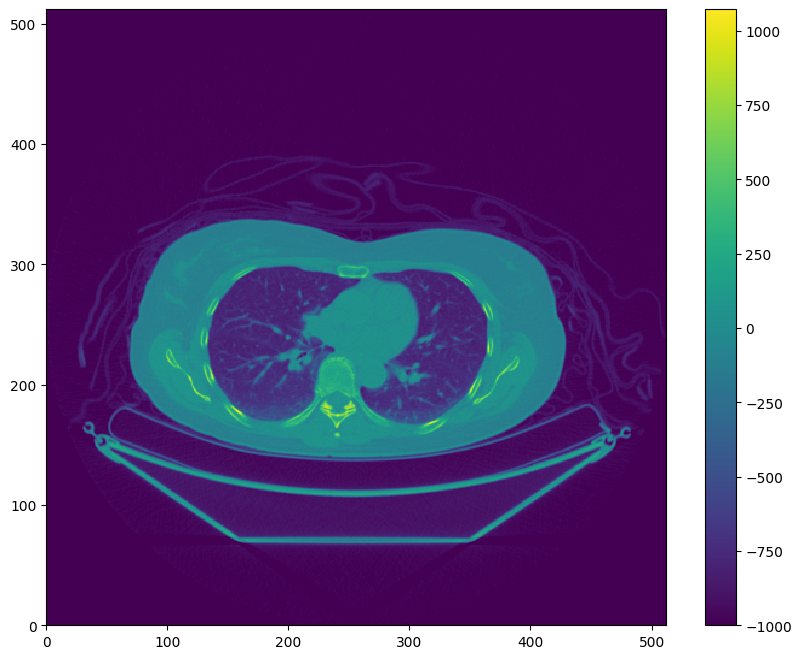

In [7]:
plt.figure(figsize = (10, 8))
plt.pcolormesh(img[170]);
plt.colorbar();

> Que signifient ces valeurs ? Les valeurs de pixels de cette tomodensitométrie (CT scan) sont exprimées en **unités de Hounsfield**.

$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

> où $\mu$ est le coefficient d'atténuation linéaire du matérial. Le coefficient d'atténuation linéaire du matérial est défini en fonction de la décroissance de l'intensité d'un faisceau de photons à mesure qu'il parcourt une distance $x$ à travers un matérial $I=I_0e^{-\mu x}$. Nous pouvons souligner que $\mu$ dépends de l'enérgie faisceau de photons, et dans un scan les photons ont une énérgie approximative de  $\approx 100$keV.

>  Les Hounsfield Units sont une échelle de valeurs numériques utilisée pour représenter la densité des tissus dans le corps humain. Cette échelle est basée sur les propriétés d'absorption des rayons X par différents matériaux. Elle attribue des valeurs numériques spécifiques aux différents tissus et matériaux du corps, en fonction de leur densité relative par rapport à l'eau. L'eau est définie comme ayant une densité de 0 HU, tandis que l'air a une densité négative (généralement autour de -1000 HU). Les tissus mous ont généralement des valeurs positives, tandis que les tissus plus denses, tels que l'os, ont des valeurs plus élevées.)


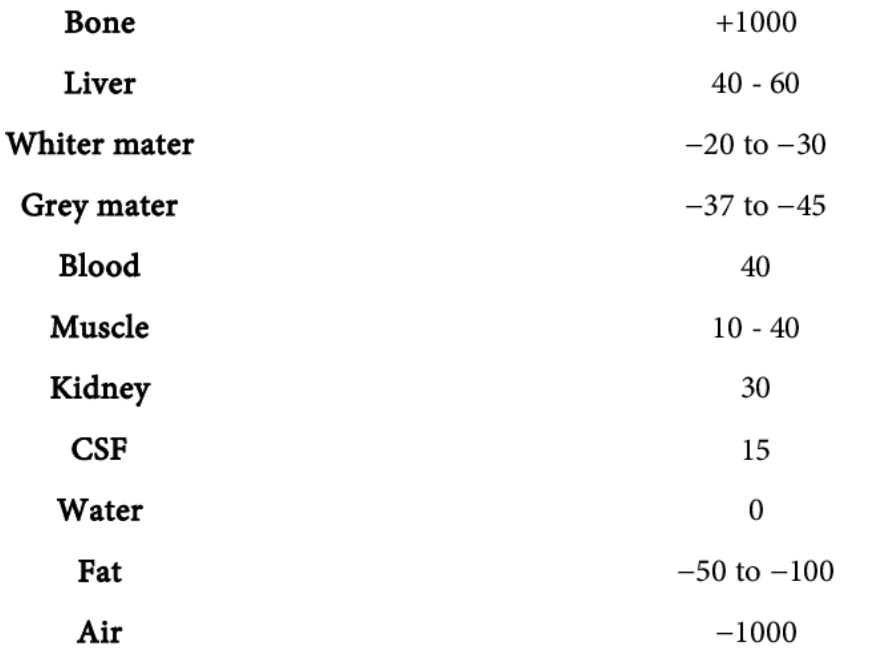


> Objectif : prendre l'image en 3D et trouver le masque pour les poumons. Le masque sera un array 3D où 1 signifie que nous sommes sur le pouumons et 0 non.
>
> La première chose à noter est que l'air a des unités Hounsfield (HU) significativement moins élevées que d'autres substances dans le corps, donc nous appliquons ce qu'on appelle un masque "seuil". Utilisons -320 HU comme limite inférieure

In [ ]:
img < -320

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

> Nous allons créer un masque et l'appliquer à notre image. Nous allons afficher 5 tranches masquées de l'image.

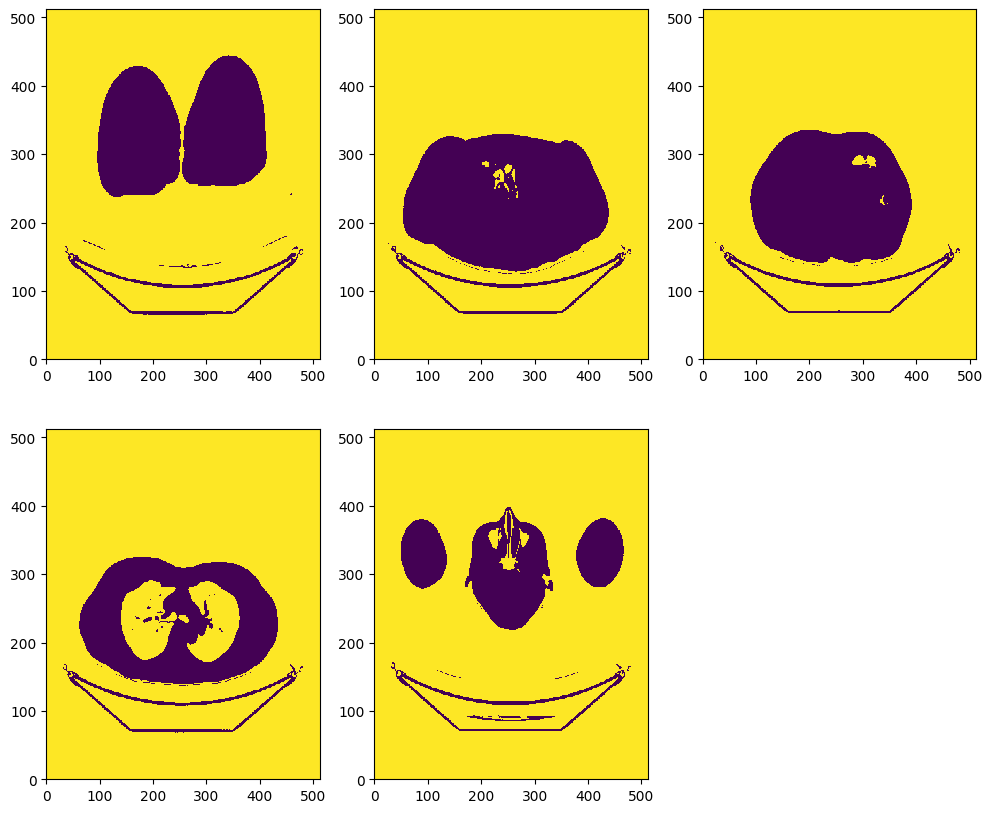

In [8]:
mask = img < -320

indexes = np.arange(0, 260, 60)

plt.figure(figsize = (12, 10))

for i, index in enumerate(indexes, start = 1) :
  plt.subplot(2,3, i)
  plt.pcolormesh(mask[index]);

> Maintenant nous pouvons utiliser la fonction `clear_border` du module `segmentation` de la librairie `Skimage`. La fonction `clear_border` est utilisée pour éliminer les objets situés en bordure d'une image. Elle permet d'éliminer les artefacts ou les objets indésirables qui se trouvent à proximité des bords de l'image.
>
> Nous allons utiliser la fonction `np.vectorize` pour appliquer la fonction `clear_border` à notre array.  De manière générale `np.vectorize` est utilisée pour vectoriser une fonction, ce qui signifie qu'elle permet d'appliquer cette fonction à chaque élément d'un tableau numpy, au lieu d'itérer explicitement sur chaque élément.

In [9]:
mask.shape

(263, 512, 512)

In [10]:
# Notre tableau mask contient maintenant
mask[170, 1, :100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

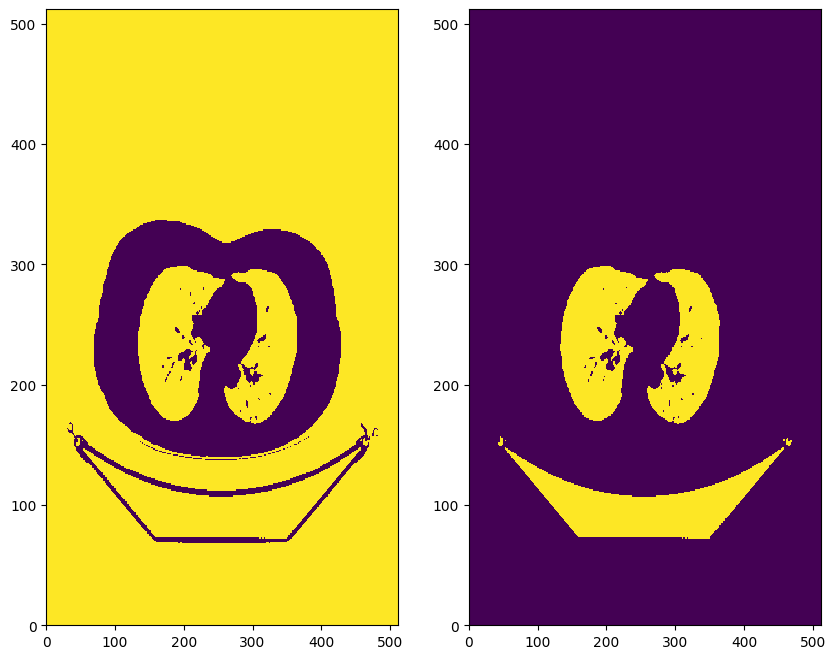

In [11]:
mask_v = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)

plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(mask[170]);

plt.subplot(1, 2, 2)
plt.pcolormesh(mask_v[170]);

> Maintenant nous pouvons labéliser chaque air (ou région) de l'image. Cela revient à attribuer un nombre entier à chaque région. Pour ce faire on peut utiliser la fonction `label` du module `skimage.measure`.
>
> La labélisation est importante car dans certaines images, deux régions séparées peuvent appertenir au même poumon (comme on peut le voir dans la deuxième image ci-dessous)

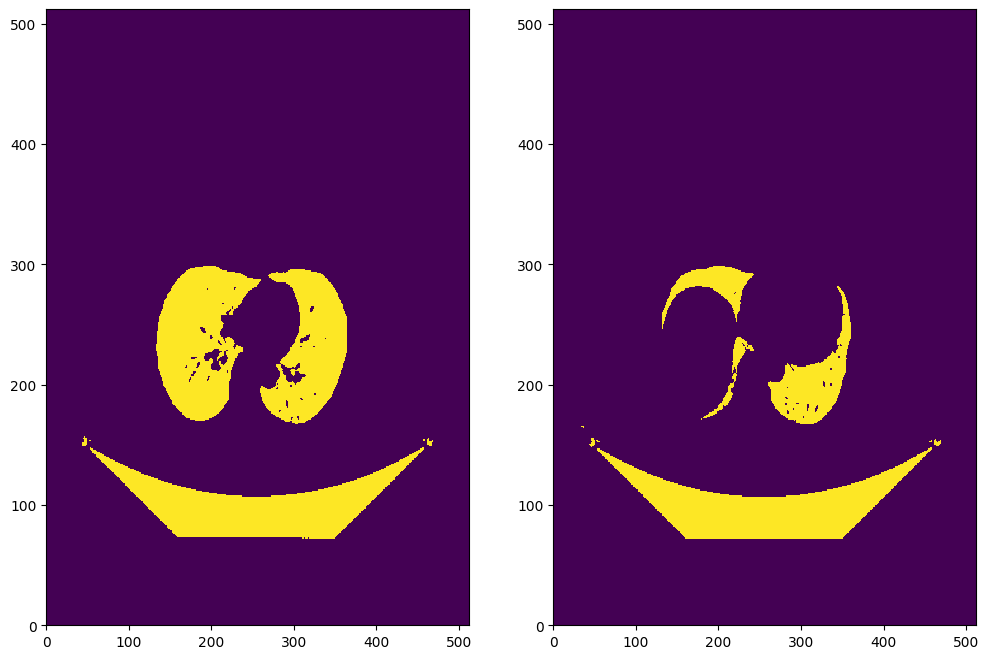

In [12]:

plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.pcolormesh(mask_v[170]);

plt.subplot(1, 2, 2)
plt.pcolormesh(mask_v[152]);

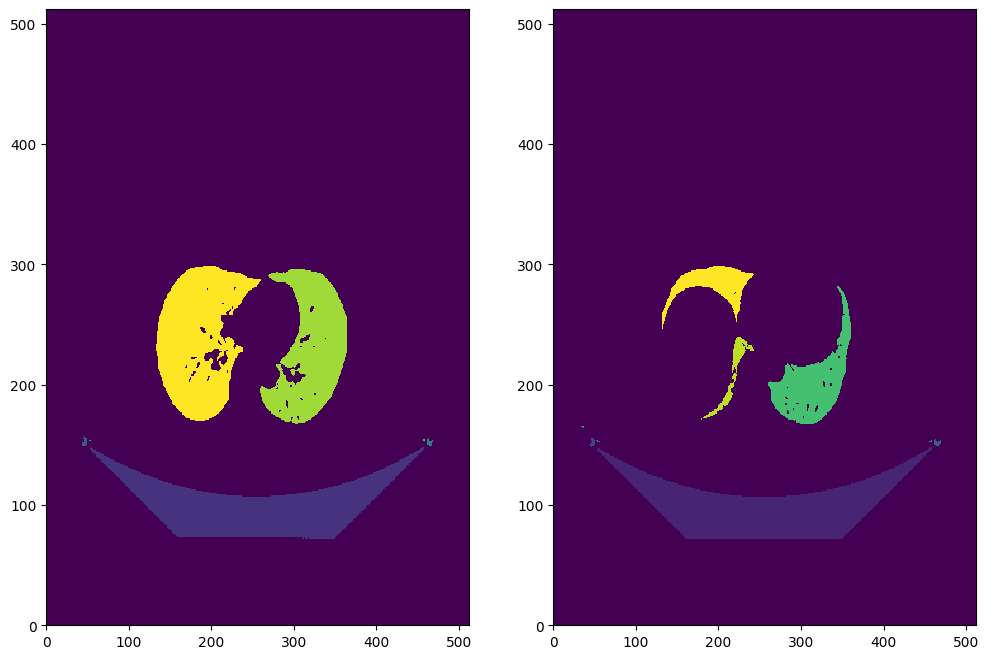

In [13]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask_v)


plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.pcolormesh(mask_labeled [170]);

plt.subplot(1, 2, 2)
plt.pcolormesh(mask_labeled[152]);

> Maintenant, pour quelque chose de légèrement contre-intuitif. Nous voulons conserver les trois plus grandes zones pour chaque tranche de l'image. Pourquoi voudrions-nous faire cela si nous ne voulons garder que les deux poumons ?
>
>> Sur certaines tranches, l'un des poumons pourrait être plus grand que la table.
>
>> Sur certaines tranches, l'un des poumons pourrait être plus petit que la table.
>
> Si nous ne prenons que les deux plus grandes tranches, nous pourrions finir par prendre la table et l'un des poumons. Donc pour l'instant, prenons les trois premières. La fonction ci-dessous est conçue pour fonctionner sur une seule tranche de l'image 3D :"

In [14]:
slc = mask_labeled[170]

In [15]:
regionprops(slc)

> Chaque élément de la liste correspond à une région (ou une propriété de région).
>
> Ces objets `RegionProperties` contiennent des informations sur les propriétés de chaque région identifiée dans une image, telles que la position, la forme, la taille, etc. Chaque objet est associé à une région spécifique de l'image.
>
> Lorsqu'on imprime la liste, nous voyons les adresses mémoire des objets RegionProperties dans la mémoire de notre ordinateur. Ces adresses mémoire sont représentées sous forme hexadécimale (par exemple, 0x7e2c67a68520). Elles servent d'identifiants uniques pour chaque objet en mémoire.
>


In [16]:
rps = regionprops(slc)
print("L'aire du premier élément est : ", rps[0].area)

for i in rps :
  print(i.area)

L'aire du premier élément est :  11529
11529
34
35
2
5
7745
9900


In [17]:
slc = mask_labeled[170]
rps = regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1] # du plus grand au plus petit
print(areas)
print(idxs)

[11529, 34, 35, 2, 5, 7745, 9900]
[0 6 5 2 1 4 3]


In [ ]:
# Je peux utiliser coords pour chercher les coordonnées x, y pour chaque pixel dans chacune des aires
coordinates = rps[0].coords
coordinates.shape
print("les coordonnées des 5 premiers pixels sont : ", coordinates[0:5, :])

les coordonnées des 5 premiers pixels sont :  [[ 72 310]
 [ 72 311]
 [ 72 314]
 [ 72 315]
 [ 72 316]]


Maintenant nous pouvons considérer uniquement les trois aires (en itérant à travers `idxs`)  les plus grandes et les ajouter à un nouveau tableau appelé `new_slc`.  

In [18]:
new_slc = np.zeros_like(slc)
print(new_slc.shape)
new_slc[0, :]

(512, 512)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

> Pour résumer nous devons :
>
>> Labéliser les différentes régions.
>
>> Récuperer les trois aires les plus grandes (calculer les aires de chaque région dans chaque table)
>
>> Rétrouver les index correspondant aux labels avec les aires les plus grandes.
>
>> Dans des nouvelles tables, ajouter les valeurs correspondantes à chaque label dans la région définies par les coordonnées de chaque label. Par exemple, chaque pixel de la région avec le label 1 aura la valeur 1.

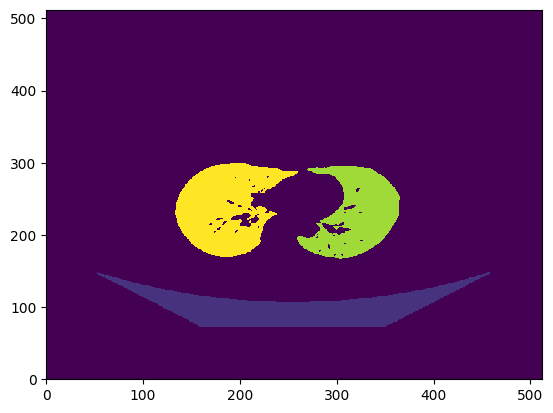

In [19]:
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1

plt.pcolormesh(new_slc);

> Créons maintenant une fonction permettant d'appliquer cette démarche à travers toutes les tables de notre image 3D.

In [20]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

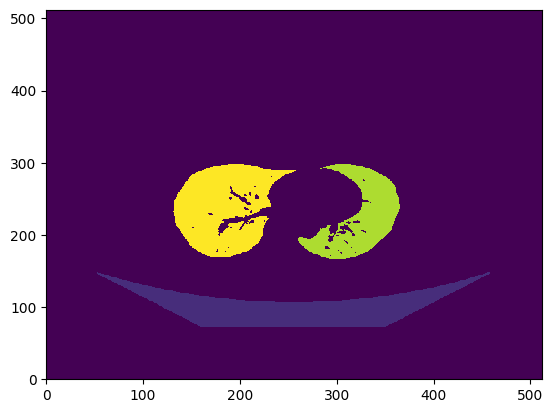

In [21]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)
plt.pcolormesh(mask_labeled[165]);

> Et maintenant on peut remplir les petits troux.

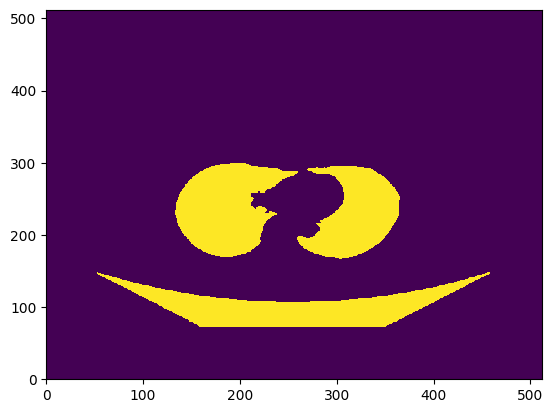

In [22]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask[170]);

"Enfin, il est temps de retirer la table. Notez que le centre de masse de la table est toujours plus bas que celui des deux poumons. Ainsi, il nous suffit simplement de supprimer le volume avec le centre de masse le plus bas en $y$ pour supprimer la table :"

In [23]:
labels = label(mask[170], background=0)

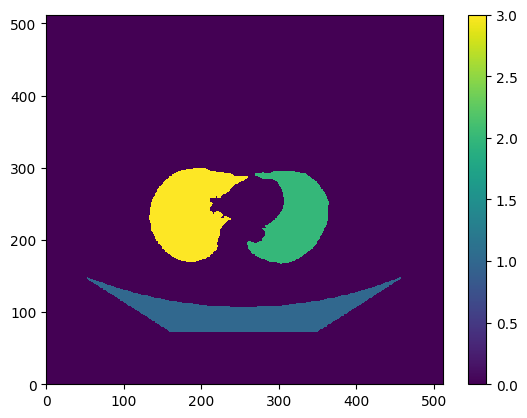

In [24]:
plt.pcolormesh(labels)
plt.colorbar();

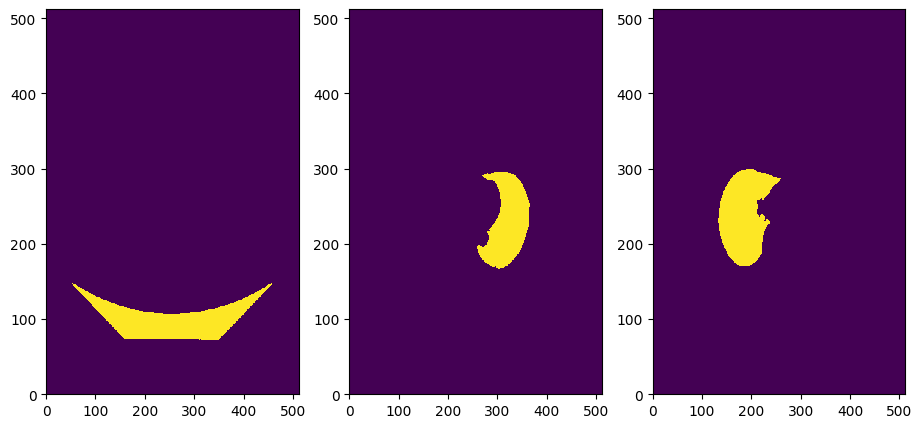

In [25]:
plt.figure(figsize = (15, 5))

for i in range(1,4) :
  plt.subplot(1,4,i)
  plt.pcolormesh(labels == i)

Calculer les centres de masse dans cette "slice"

In [27]:
center_of_mass(labels==3)
# la première valeur correspond à la coordonnées sur y et la deuxième à la coordonnée sur x

(237.06954832442935, 185.5185041282176)

In [28]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc,  background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

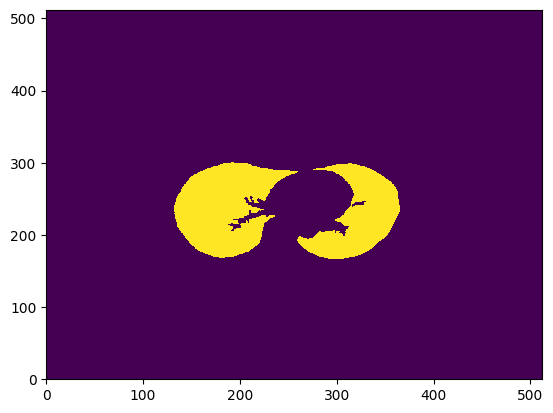

In [29]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_new[167]);

Enfin, nous pouvons étendre un peu la surface des poumons en agrandissant la bordure. Pour cela, nous pouvons utiliser la fonction `binary_dilation` :

In [30]:
mask_new = binary_dilation(mask_new, iterations=5)

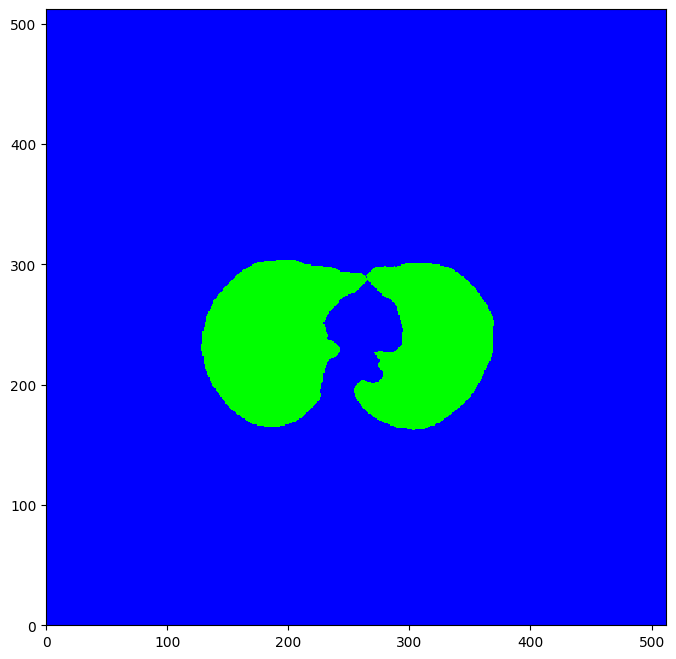

In [31]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new[170], cmap='brg')

Traçons l'image 3D complète dans plotly et créons un tracé interactif :

* Diminuons d'abord légèrement la résolution :

In [32]:
im = zoom(1*(mask_new), (0.1, 0.1, 0.1))
print(im.shape)

(26, 51, 51)


In [33]:
print(im.shape)

(26, 51, 51)


Obtenir des tableaux de $x$, $y$ et $z$. Dans un scanner, la différence entre les pixels dans la direction z est environ 4 fois plus grande que dans les directions $x$ et $y$ :

In [34]:
z, y, x = [np.arange(i) for i in im.shape]
z*=4

Creation du meshgrid pour le 3D:

In [35]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

Creation du plot en 3D

In [36]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(img,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1,
    surface_count=17,
    ))
fig.write_html("test_img.html")

In [37]:
img_new = mask_new * img

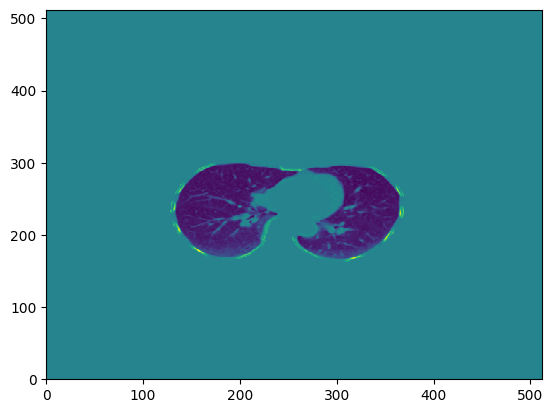

In [38]:
plt.pcolormesh(img_new[170])

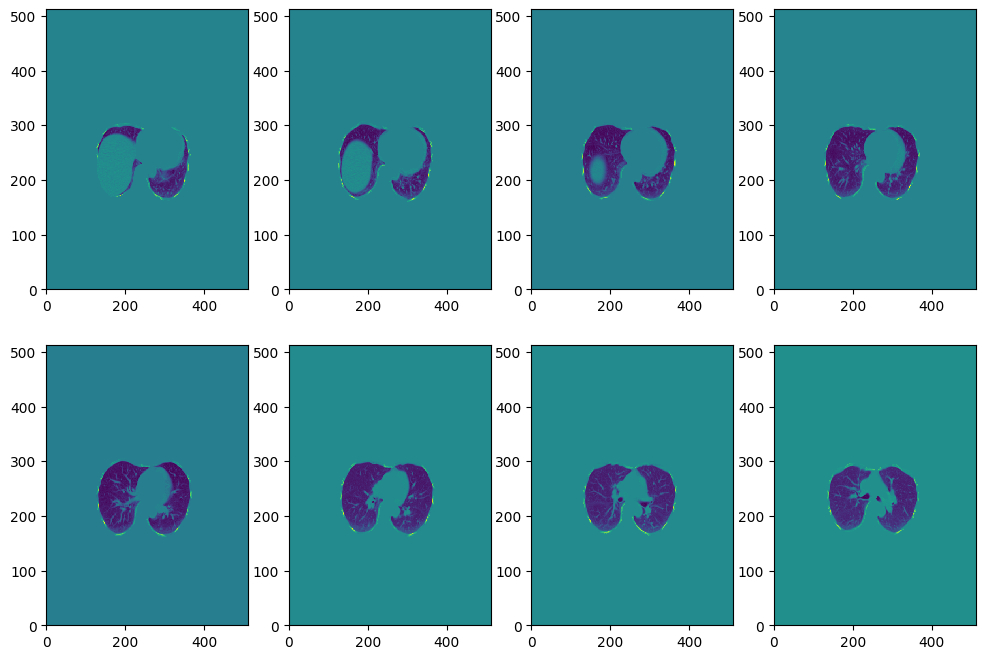

In [50]:
slices = np.arange(1, 30, 4)
plt.figure(figsize = (12, 8))

for idx, i in enumerate(slices):
    plt.subplot(2, 4, idx + 1)
    plt.pcolormesh(img_new[150 + i])

In [40]:
z

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100])

In [42]:
len(X)

51